In [1]:
import matplotlib.pyplot as plt
# Audio processing
import librosa
import noisereduce
# Data cleaning
import pandas as pd
import numpy as np
from numpy import mean, var
# Machine learning
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Advanced options
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import pickle

In [2]:
FRAMESIZE = 1024
HOPLENGTH = 512
MELS = 13

In [3]:
X = pd.read_csv('..\\data\\speaker_data.csv')
y = pd.read_csv('..\\data\\speaker_target.csv')
x_train, x_test, _, _ = train_test_split(X, y, test_size=0.3)

# performing preprocessing part
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


classifier_path = '..\\models\\rf_speaker_mod.pkl'
with open(classifier_path, 'rb') as c:
    classifier = pickle.load(c)

In [4]:
# Functions we will use
def transform_audio(audio, FRAMESIZE, HOPLENGTH, MELS):

    audio_noised, sr = librosa.load(audio, duration=2)
    audio_array = noisereduce.reduce_noise(y=audio_noised, sr=sr)
    # audio_array, sr = librosa.load(audio, duration=2)

    log_mel_audio_list_mean = []
    log_mel_audio_list_var = []
    mfccs_audio_list_mean = []
    mfccs_audio_list_var = []
    cqt_audio_list_mean = []
    cqt_audio_list_var = []
    chromagram_audio_list_mean = []
    chromagram_audio_list_var = []
    tone_audio_list_mean = []
    tone_audio_list_var = []

    log_mel_audio = librosa.power_to_db(librosa.feature.melspectrogram(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH, n_mels=MELS))
    mfccs_audio = librosa.feature.mfcc(y=audio_array, n_mfcc=MELS, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)

    cqt_audio = np.abs(librosa.cqt(y=audio_array, sr=sr, hop_length=HOPLENGTH))
    chromagram_audio = librosa.feature.chroma_stft(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
    tone_audio = librosa.feature.tonnetz(y=audio_array, sr=sr)

    for i in range(len(log_mel_audio)):
         log_mel_audio_list_mean.append(log_mel_audio[i].mean())
         log_mel_audio_list_var.append(log_mel_audio[i].var())

    for i in range(len(mfccs_audio)):
         mfccs_audio_list_mean.append(mfccs_audio[i].mean())
         mfccs_audio_list_var.append(mfccs_audio[i].var())

    for i in range(len(cqt_audio)):
         cqt_audio_list_mean.append(cqt_audio[i].mean())
         cqt_audio_list_var.append(cqt_audio[i].var())

    for i in range(len(chromagram_audio)):
         chromagram_audio_list_mean.append(chromagram_audio[i].mean())
         chromagram_audio_list_var.append(chromagram_audio[i].var())

    for i in range(len(tone_audio)):
         tone_audio_list_mean.append(tone_audio[i].mean())
         tone_audio_list_var.append(tone_audio[i].var())

    sb_audio = librosa.feature.spectral_bandwidth(y=audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)

    ae_audio = fancy_amplitude_envelope(audio_array, FRAMESIZE, HOPLENGTH)
    rms_audio = librosa.feature.rms(audio_array, frame_length=FRAMESIZE, hop_length=HOPLENGTH)

    return np.hstack((mean(ae_audio), var(ae_audio), mean(rms_audio), var(rms_audio), mean(sb_audio), var(sb_audio), chromagram_audio_list_mean, chromagram_audio_list_var, tone_audio_list_mean, tone_audio_list_var, cqt_audio_list_mean, cqt_audio_list_var, mfccs_audio_list_mean, mfccs_audio_list_var, log_mel_audio_list_mean, log_mel_audio_list_var))


def fancy_amplitude_envelope(signal, framesize, hoplength):
    return np.array([max(signal[i:i+framesize]) for i in range(0, len(signal), hoplength)])

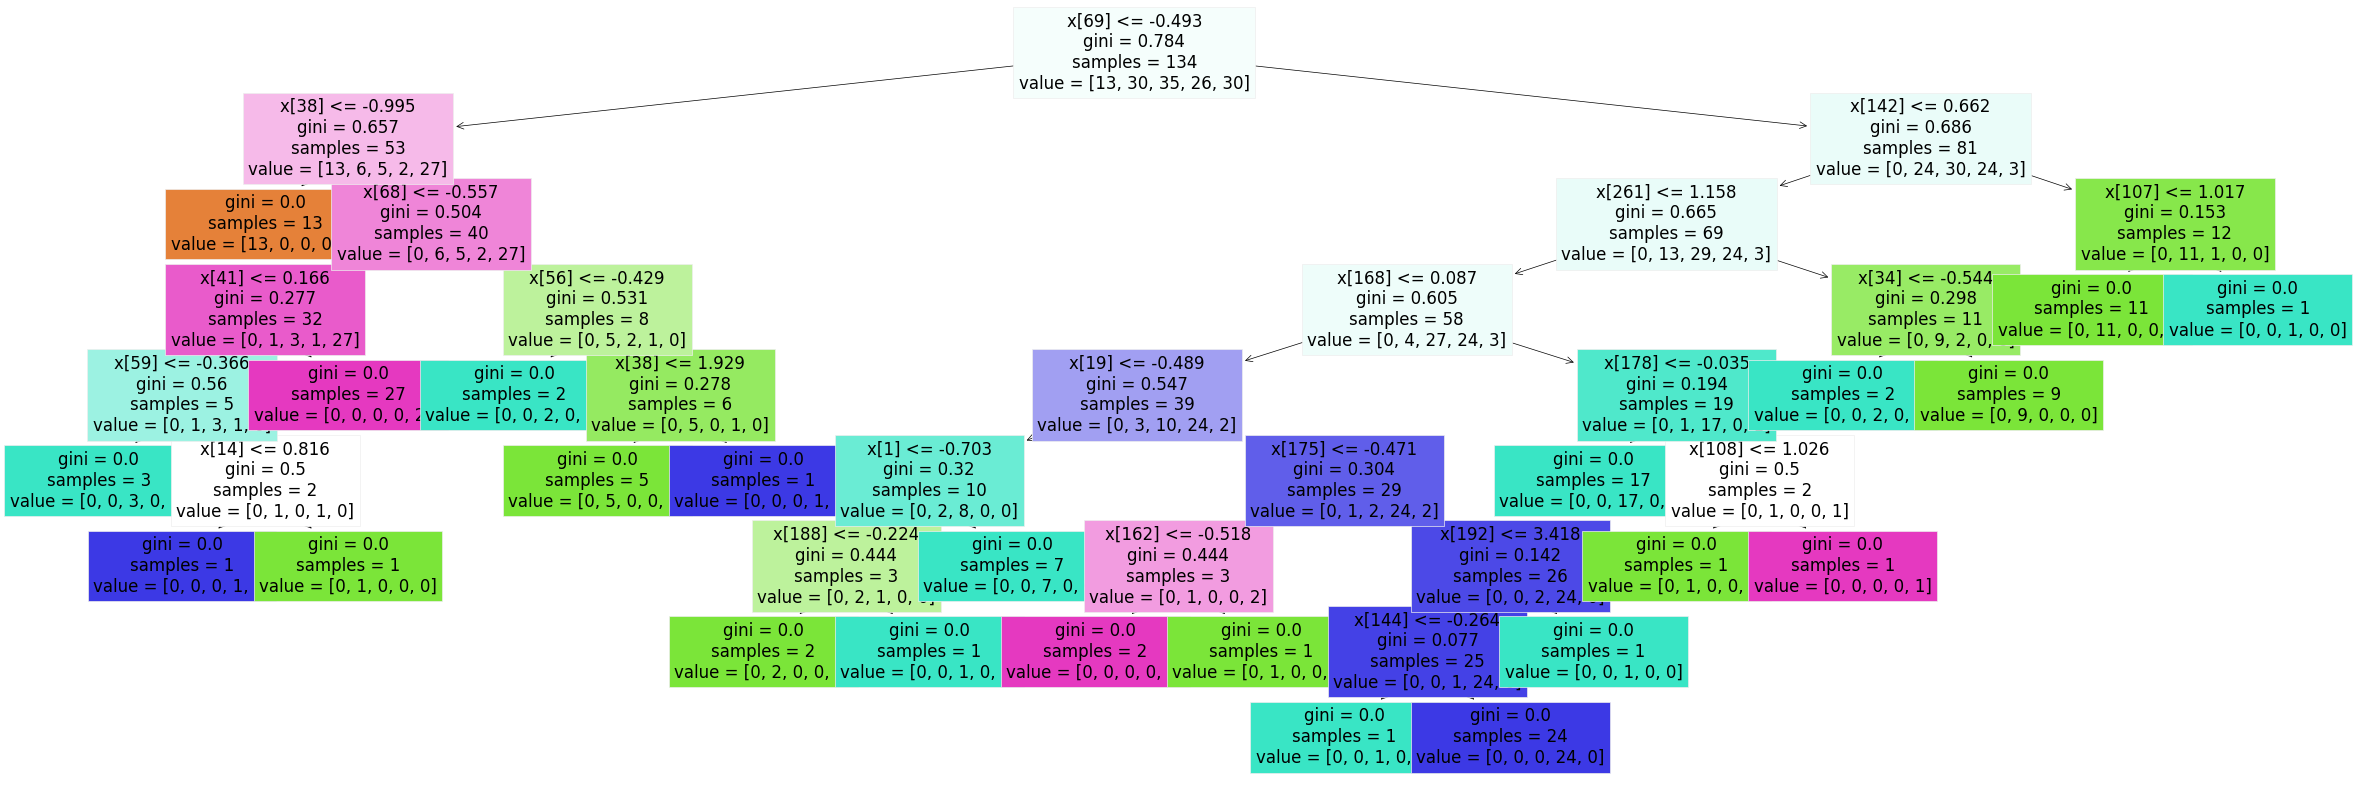

In [5]:
# Plot the decision tree for the first estimator in the random forest
classifier_tree = classifier.estimators_[0]
# Plot the decision tree using matplotlib
plt.figure(figsize=(30, 10))
tree.plot_tree(classifier_tree, filled=True, fontsize=12)
plt.show()

In [6]:
def plot_feature_importance_scatter(X, sc, classifier, audio, FRAMESIZE, HOPLENGTH, MELS, features_number=10):
    user_input = transform_audio(audio, FRAMESIZE, HOPLENGTH, MELS)
    user_input = sc.transform(user_input.reshape(1,-1))

    user_prediction = classifier.predict(user_input)
    confidence_score = classifier.predict_proba(user_input)[0][user_prediction[0]]

    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1][:features_number]

    fig, ax = plt.subplots(figsize=(7,5))
    c = ax.scatter(importances[indices], range(features_number), c=[confidence_score]*features_number, cmap='Blues')
    ax.set_yticks(range(features_number))
    ax.set_yticklabels(X.columns[indices])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Feature Importance Plot Based on Confidence Score')
    ax.text(0.95, 0.95, 'Input Confidence Score: {:.2f}'.format(confidence_score), ha='right', va='bottom', transform=ax.transAxes, fontsize=12)
    plt.colorbar(c, ax=ax).set_label('Confidence Score')
    plt.tight_layout()
    plt.show()

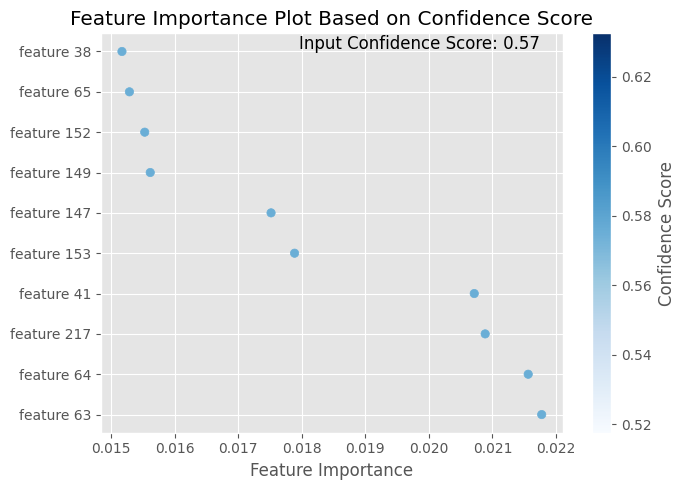

In [7]:
audio = 'A:\\Professional\\Engineering CU\\DSP_Data_New\\open the door\\adham_otd2.wav'
plot_feature_importance_scatter(X, sc, classifier, audio, FRAMESIZE, HOPLENGTH, MELS)

In [8]:
def plot_feature_importance_bar(X, sc, classifier, audio, FRAMESIZE, HOPLENGTH, MELS, features_number=10):
    user_input = transform_audio(audio, FRAMESIZE, HOPLENGTH, MELS)
    user_input = sc.transform(user_input.reshape(1,-1))

    # Make a prediction on the user's input data
    user_prediction = classifier.predict(user_input)

    # Get the confidence score of the prediction
    confidence_score = classifier.predict_proba(user_input)[0][user_prediction[0]]

    # Get the feature importances from the classifier
    importances = classifier.feature_importances_

    # Get the indices of the top 20 most important features
    indices = np.argsort(importances)[::-1][:features_number]

    # Plot the feature importances of the top 20 features based on the confidence score
    fig, ax = plt.subplots(figsize=(7,5))
    ax.barh(range(features_number), importances[indices], align='center', color='gray')
    ax.set_yticks(range(features_number))
    ax.set_yticklabels(X.columns[indices])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Feature Importance Plot Based on Confidence Score')
    ax.text(0.95, 0.96, 'Input Confidence Score: {:.2f}'.format(confidence_score), ha='right', va='bottom', transform=ax.transAxes, fontsize=10)
    plt.tight_layout()
    plt.show()

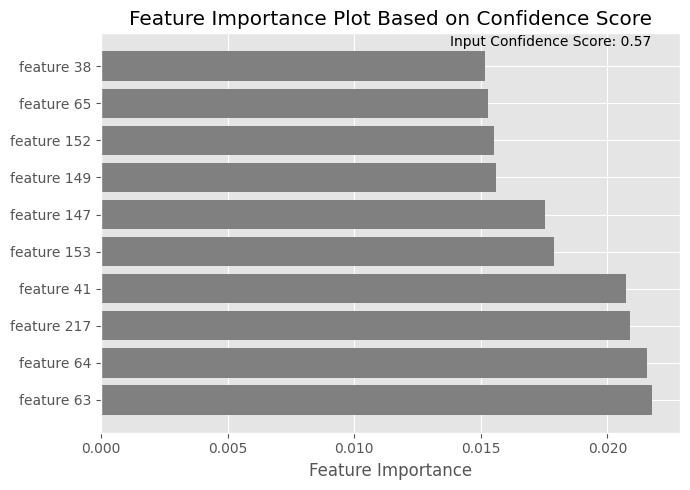

In [9]:
audio = 'A:\\Professional\\Engineering CU\\DSP_Data_New\\open the door\\adham_otd2.wav'
plot_feature_importance_bar(X, sc, classifier, audio, FRAMESIZE, HOPLENGTH, MELS)